In [1]:
import pickle
from distutils.dir_util import copy_tree
with open('/home/jislam/Documents/gits/igosip/extra_scripts/src.py') as f:
    exec(f.read())
torch.manual_seed(1)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set(style="whitegrid")
#from lifelines import CoxPHFitter
#from captum.attr import DeepLiftShap

/home/jislam/.local/lib/python3.10/site-packages/gosip/__init__.py:5: FutureWarning: In the future `np.ulong` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'ulong'):


In [2]:
min_optuna=10
hyperparam_epochs=200 #max per trial(note that we add burn in inside the loop
hyperparam_trials=100 #number of trials for each model.
patience=5
burn_in=10
num_epochs=1000
k=100
bsize=2048
zi=False
validation_ratio=0.2 #10% of dataset is kept for validation during training. we do not use a testing set since we're only interested in what it learned not generalizability.


main_path="/home/jislam/Documents/gits/igosip/analyses/nozig/"
dataLocation="/home/jislam/Documents/gits/scRNAseq_datasets/hpap_batch_corrected.final3k.h5ad"
filter_by="cell_type"
categories_to_keep = 8 #number of cell types I want to keep in the model sorted by decreasing cell count, can use all but only so much weighted losses can do...
category_labels=["cell_disease"] # See adata.obs.columns for what categories you can use here. Specify which columns to one-hot-encode and use to inform the models. cell_disease is generated for the interaction.

group_a=["beta_cell_T2D"]
group_b=["beta_cell_Control"]
shared_filter =None

single_cell_data="hpapnb3k"



outdir=single_cell_data.replace(" ", "_")
if not os.path.exists(outdir):
    os.makedirs(outdir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

adata=sc.read_h5ad(dataLocation)
adata.obs['cell_type']=adata.obs['cell_type'].str.replace(" ", "_", regex=False)
adata=adata[adata.obs["disease_state"]!="AAB"]
adata=adata[adata.obs["disease_state"]!="T1D"]
adata=adata[adata.obs["cell_type"]!="unknown"]
adata= adata[adata.obs['cell_type'].isin(['alpha_cell', 'delta_cell', 'beta_cell', 'PP_cell','acinar_cell'])]#, 'precursor_alpha_beta_cell'
#adata.obs.loc[adata.obs['cell_type']=='precursor_alpha_beta_cell','cell_type']="precursor_cell"

adata.obs["cell_disease"]=adata.obs["cell_type"].astype(str) + '_' + adata.obs["disease_state"].astype(str)

one_hot_labels, num_categories= gosip.one_hot_encode_combinations(adata.obs, category_labels)
adata.one_hot_labels= one_hot_labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

adata.obs['cell_disease'].unique()

/tmp/ipykernel_465693/2348216859.py:41: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["cell_disease"]=adata.obs["cell_type"].astype(str) + '_' + adata.obs["disease_state"].astype(str)


array(['alpha_cell_Control', 'delta_cell_Control', 'beta_cell_Control',
       'acinar_cell_Control', 'PP_cell_Control', 'alpha_cell_T2D',
       'beta_cell_T2D', 'acinar_cell_T2D', 'delta_cell_T2D',
       'PP_cell_T2D'], dtype=object)

/tmp/ipykernel_465693/318763591.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_465693/318763591.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


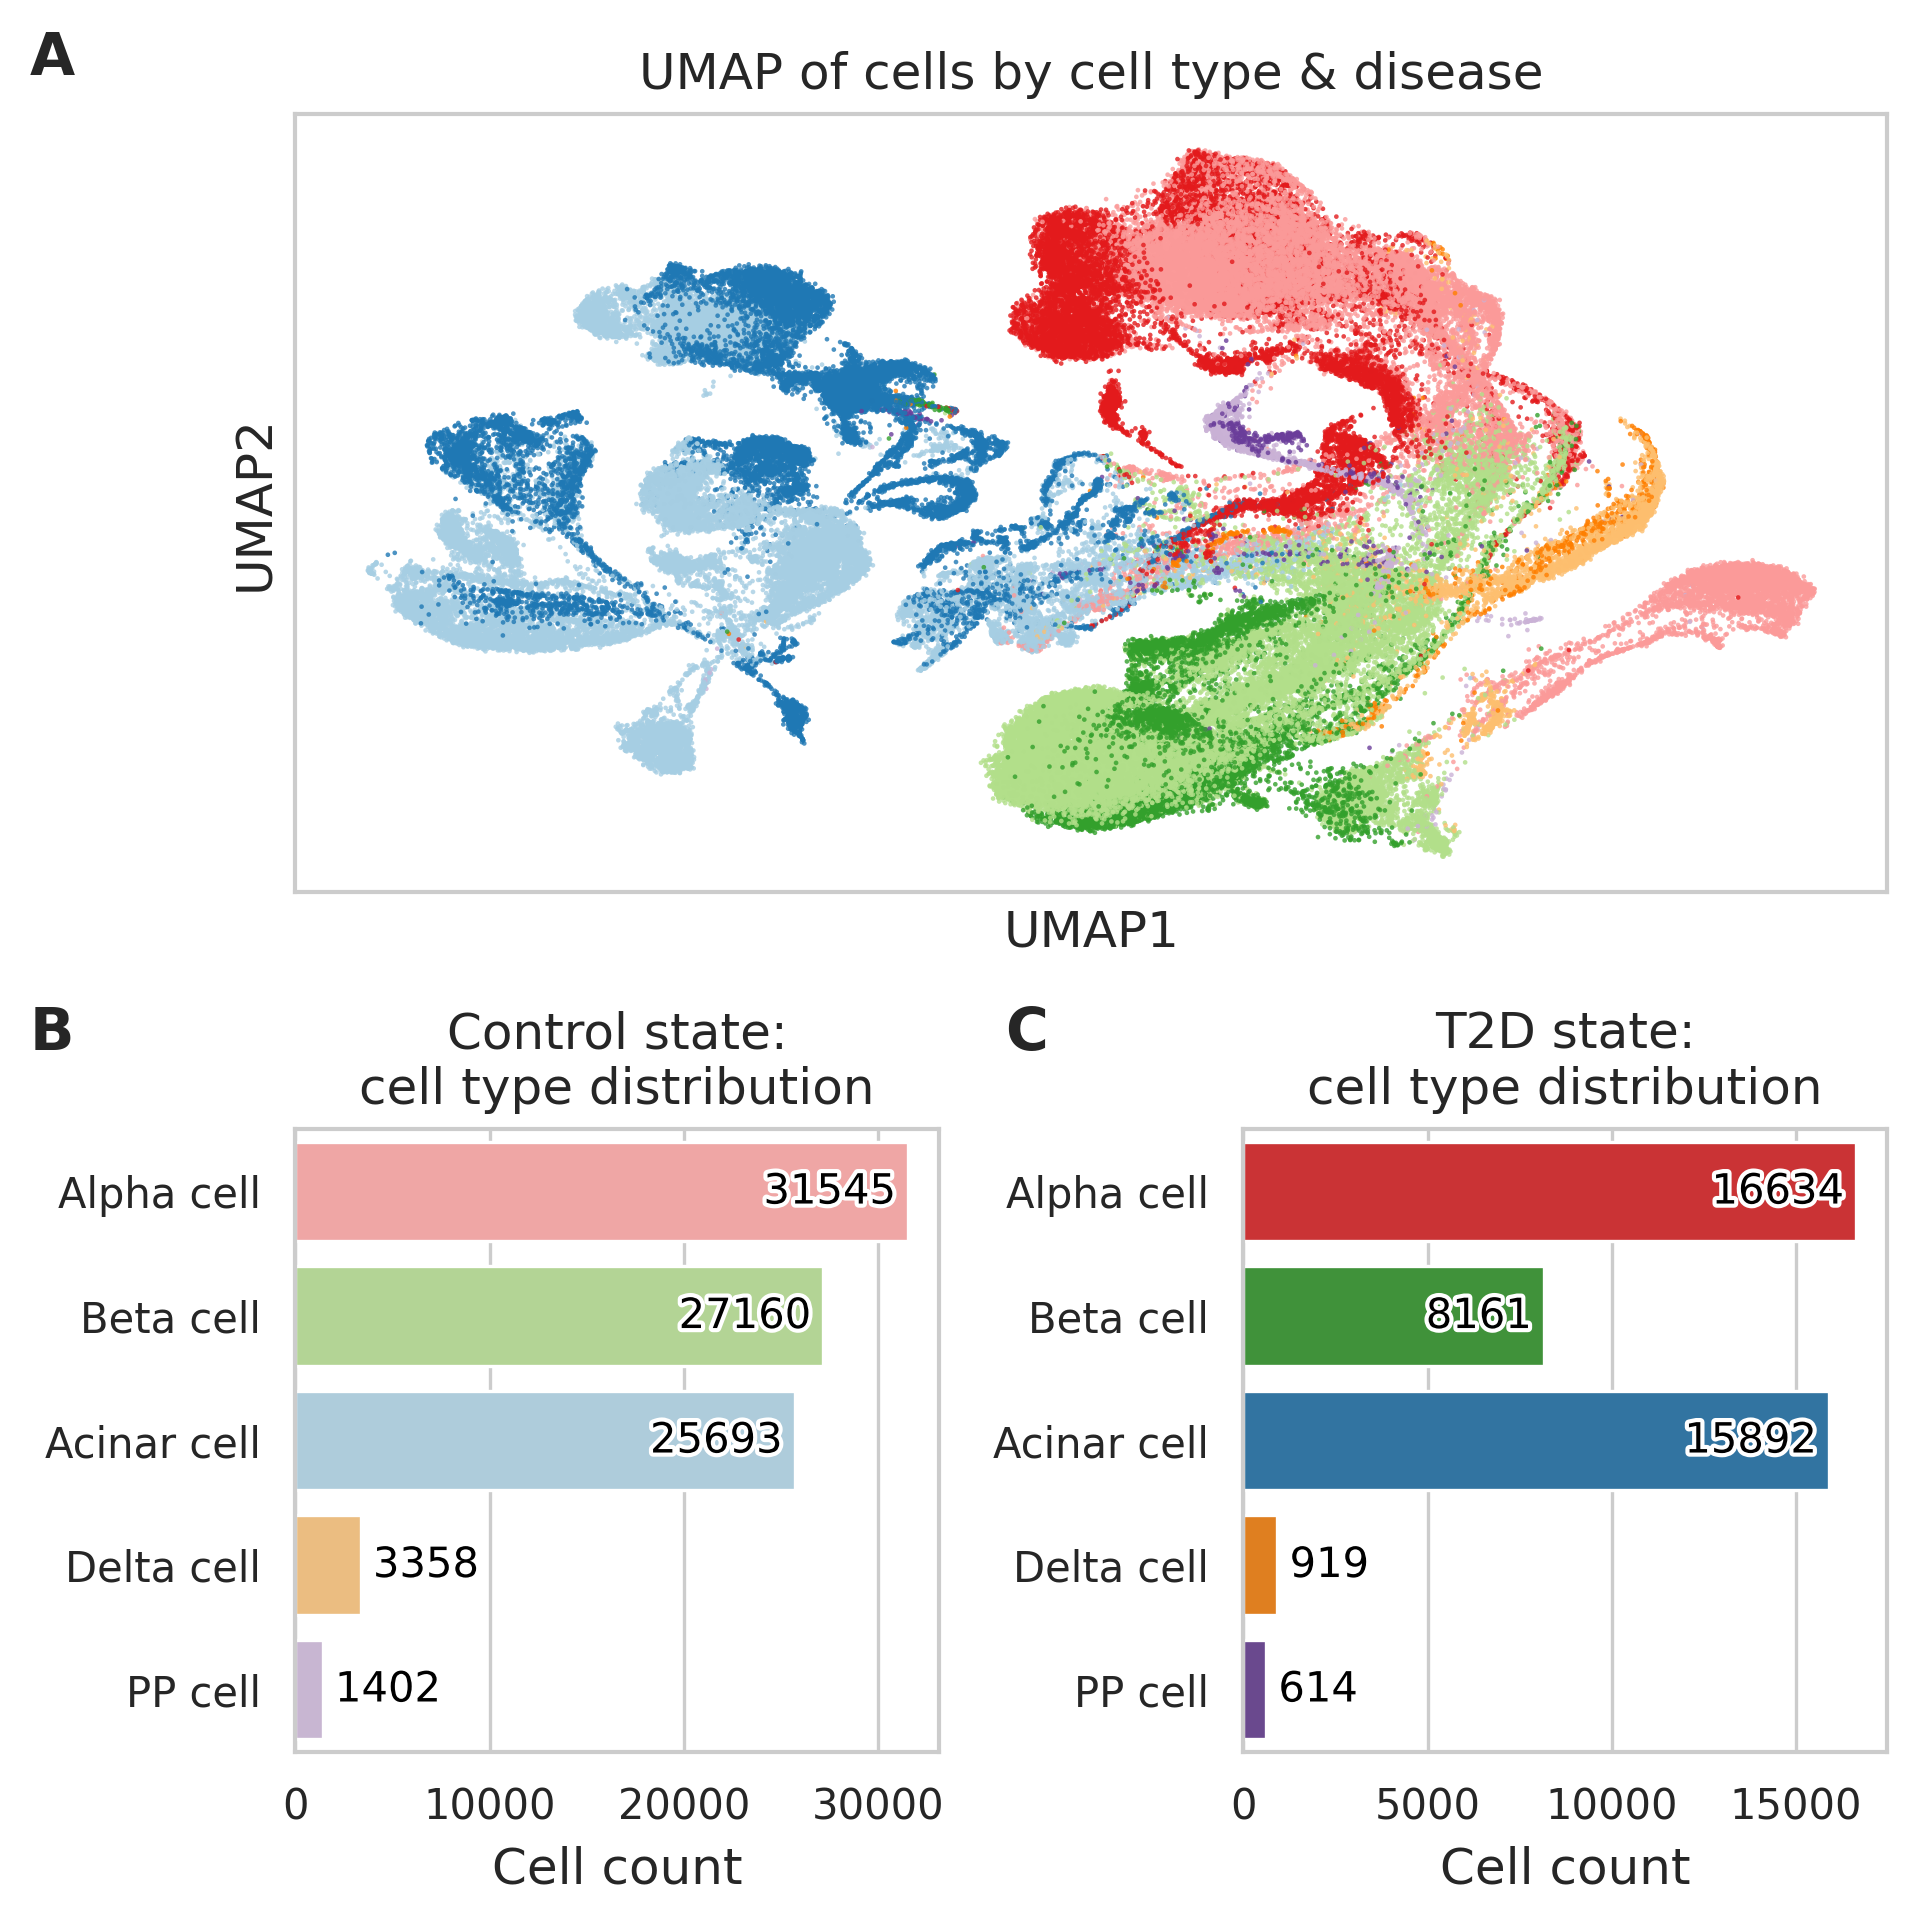

In [5]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from matplotlib import patheffects as pe

def plot_cell_umap_and_distributions(adata, output_file="hpap.pdf"):
    """
    3‐panel figure:
      A) UMAP colored by cell_type×disease_state (10 colors; no legend)
      B) Control barplot, C) T2D barplot,
    with counts placed inside bars ≥20% of max, else outside, all in black
    with white outline.
    """
    # 1) Publication styling
    sns.set_context("paper", font_scale=1.2)
    rcParams.update({
        "font.size":       12,
        "axes.titlesize":  12,
        "axes.labelsize":  12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi":     300,
    })
    
    # 2) Cell‐types, pretty names, 10‐color palette
    cell_types = ["alpha_cell","beta_cell","acinar_cell","delta_cell","PP_cell"]
    pretty = {
        "alpha_cell":"Alpha cell",
        "beta_cell": "Beta cell",
        "acinar_cell":"Acinar cell",
        "delta_cell":"Delta cell",
        "PP_cell":   "PP cell"
    }
    combos = [f"{ct}_Control" for ct in cell_types] + [f"{ct}_T2D" for ct in cell_types]
    combo_palette = dict(zip(combos, sns.color_palette("tab10", n_colors=len(combos))))

    
    # 2’) Define a colorblind‐safe paired palette
    base_colors = {
        "alpha_cell": "#fb9a99",
        "beta_cell":  "#b2df8a",
        "acinar_cell":"#a6cee3",
        "delta_cell": "#fdbf6f",
        "PP_cell":    "#cab2d6",
    }
    dark_colors = {
        "alpha_cell": "#e31a1c",
        "beta_cell":  "#33a02c",
        "acinar_cell":"#1f78b4",
        "delta_cell": "#ff7f00",
        "PP_cell":    "#6a3d9a",
    }
    
    # build the 10‐category palette
    combo_palette = {}
    for ct in cell_types:
        combo_palette[f"{ct}_Control"] = base_colors[ct]
        combo_palette[f"{ct}_T2D"]     = dark_colors[ct]
    
    # 3) Figure & gridspec
    fig = plt.figure(figsize=(6.5, 6.5))
    gs  = fig.add_gridspec(2, 2, height_ratios=[1, 0.8])
    
    # — Panel A: UMAP —
    ax0 = fig.add_subplot(gs[0, :])
    sc.pl.umap(
        adata,
        color="cell_disease",
        palette=combo_palette,
        ax=ax0,
        show=False,
        s=5, alpha=0.8
    )
    ax0.set_title("UMAP of cells by cell type & disease")
    if ax0.get_legend(): 
        ax0.legend_.remove()
    
    # — Panels B & C: barplots —
    for col, state in enumerate(["Control", "T2D"]):
        ax = fig.add_subplot(gs[1, col])
        sub    = adata.obs.query("disease_state == @state")
        counts = sub["cell_type"].value_counts().reindex(cell_types)
        
        # draw bars
        colors = [combo_palette[f"{ct}_{state}"] for ct in counts.index]
        sns.barplot(
            x=counts.values,
            y=[pretty[ct] for ct in counts.index],
            palette=colors,
            ax=ax
        )
        
        # two‐line title
        ax.set_title(f"{state} state:\ncell type distribution", loc="center")
        ax.set_xlabel("Cell count")
        ax.set_ylabel("")
        
        # 5% white margin on the right
        maxc = counts.max()
        ax.set_xlim(0, maxc * 1.05)
        
        # annotate: inside if ≥20% of max, else outside
        threshold = maxc * 0.20
        offset    = maxc * 0.02
        
        for x, y in zip(counts.values, range(len(counts))):
            if x >= threshold:
                # inside
                xpos, ha = x - offset, "right"
            else:
                # outside
                xpos, ha = x + offset, "left"
            
            txt = ax.text(
                xpos, y, str(x),
                va="center", ha=ha,
                color="black", fontsize=10,
                clip_on=False
            )
            # white outline
            txt.set_path_effects([
                pe.Stroke(linewidth=2, foreground="white"),
                pe.Normal()
            ])
    
    # 4) Adjust spacing
    fig.subplots_adjust(
        left=0.08, right=0.98,
        top=0.94,  bottom=0.08,
        wspace=0.4, hspace=0.3
    )
    
    # 5) Panel letters
    fig.text(0.02, 0.96, "A", fontsize=14, fontweight="bold")
    fig.text(0.02, 0.46, "B", fontsize=14, fontweight="bold")
    fig.text(0.52, 0.46, "C", fontsize=14, fontweight="bold")
    
    # 6) Save
    plt.tight_layout()
    fig.savefig(output_file)

    plt.show()
    plt.close(fig)


plot_cell_umap_and_distributions(adata, output_file=f'{main_path}{single_cell_data}/hpapnb-batch_corrected.png')
#fig.savefig()